In [11]:
import iris
import numpy as np
import matplotlib.pyplot as plt
import iris.quickplot as qplt
import warnings

# Set the global warning filter to ignore all warnings
warnings.simplefilter("ignore")

In [76]:
def expand_cubes(cube, ntime):
    # Create a new data array with shape (7, 960, 1280)
    expanded_data = np.repeat(cube.data[np.newaxis, ...], ntime, axis=0)
    expanded_data.shape
    
    # Create a new time coordinate
    time_coord = iris.coords.DimCoord(np.arange(ntime), standard_name='time', units='hours')
    
    # Create the expanded cube
    expanded_cube = iris.cube.Cube(
        expanded_data,
        long_name=cube.long_name,
        var_name=cube.var_name,
        units=cube.units,
        dim_coords_and_dims=[(time_coord, 0)] + [(coord, i+1) for i, coord in enumerate(cube.dim_coords)]
    )
    return expanded_cube

In [143]:
data_files = ['/data/scratch/prince.xavier/SALMON/raw_data/mogreps/mogreps_bucket/20250101/000/englaa_pd000.pp', '/data/scratch/prince.xavier/SALMON/raw_data/mogreps/mogreps_bucket/20250101/000/englaa_pd024.pp', '/data/scratch/prince.xavier/SALMON/raw_data/mogreps/mogreps_bucket/20250101/000/englaa_pd048.pp', '/data/scratch/prince.xavier/SALMON/raw_data/mogreps/mogreps_bucket/20250101/000/englaa_pd072.pp', '/data/scratch/prince.xavier/SALMON/raw_data/mogreps/mogreps_bucket/20250101/000/englaa_pd096.pp', '/data/scratch/prince.xavier/SALMON/raw_data/mogreps/mogreps_bucket/20250101/000/englaa_pd120.pp', '/data/scratch/prince.xavier/SALMON/raw_data/mogreps/mogreps_bucket/20250101/000/englaa_pd144.pp', '/data/scratch/prince.xavier/SALMON/raw_data/mogreps/mogreps_bucket/20250101/000/englaa_pd168.pp']
data_files.sort()
len(mog_files)

8

In [144]:
varname = 'precipitation_amount'
mem = 0
realiz_coord = iris.coords.DimCoord([int(mem)], standard_name='realization',
                                                        var_name='realization')
                    
cubes = []
for data_file in data_files:
    # Some files have 3 hourly wind data which need to be averaged
    cube = iris.load_cube(data_file, varname)
    if len(cube.shape) == 3:
        cube = cube.collapsed('time', iris.analysis.MEAN)
    if cube.coord('forecast_period').bounds is None:
        bounds = [[cube.coord('forecast_period').points[0] - 1., cube.coord('forecast_period').points[0] + 1.]]
        cube.coord('forecast_period').bounds = bounds
    if cube.coord('time').bounds is None:
        bounds = [[cube.coord('time').points[0] - 1., cube.coord('time').points[0] + 1.]]
        cube.coord('time').bounds = bounds

    # Massaging the data for mergine
    for coord in ['forecast_reference_time', 'realization', 'time']:
        cube.remove_coord(coord) if cube.coords(coord) else None
    cube.add_aux_coord(realiz_coord)
    cube.coord('forecast_period').points = cube.coord('forecast_period').bounds[:, 1]

    cubes.append(cube)

In [145]:
for i, cube in enumerate(cubes):
    #print(f"Cube {i} metadata:\n{cube.metadata}\n")
    cube.cell_methods = cubes[0].cell_methods
    if cube.coords("forecast_period"):
        new_fp = iris.coords.DimCoord(
            cube.coord("forecast_period").points, 
            standard_name="forecast_period",
            units=cube.coord("forecast_period").units
        )
        cube.replace_coord(new_fp)
    print(cube)

precipitation_amount / (kg m-2)     (latitude: 960; longitude: 1280)
    Dimension coordinates:
        latitude                             x               -
        longitude                            -               x
    Scalar coordinates:
        forecast_period             0.0 hours
        realization                 0
    Cell methods:
        0                           time: mean (interval: 1 hour)
    Attributes:
        STASH                       m01s05i226
        source                      'Data from Met Office Unified Model'
        um_version                  '11.9'
precipitation_amount / (kg m-2)     (latitude: 960; longitude: 1280)
    Dimension coordinates:
        latitude                             x               -
        longitude                            -               x
    Scalar coordinates:
        forecast_period             24.0 hours
        realization                 0
    Cell methods:
        0                           time: mean (interval: 

In [146]:
iris.cube.CubeList(cubes).merge_cube()

<iris 'Cube' of precipitation_amount / (kg m-2) (forecast_period: 8; latitude: 960; longitude: 1280)>

In [95]:
cube = iris.load_cube(mog_files, 'precipitation_amount')
cube.data[1:] -= cube.data[:-1]

In [102]:
cube = iris.load_cube(mog_files[0], 'precipitation_amount')
#cubes = [cube for i in range(7)]
cubes = expand_cubes(cube, len(mog_files))
time_unit = cube.coord('time').units
#cubes.coord('time').units = time_units
#print(cubes.coord('time')) 

In [103]:
for i, data_file in enumerate(mog_files):
    # Some files have 3 hourly wind data which need to be averaged
    cube = iris.load_cube(data_file, 'precipitation_amount')
    if len(cube.shape) == 3:
        cube = cube.collapsed('time', iris.analysis.MEAN)
    cubes.data[i] = cube.data
    cube.add_aux_coord(iris.coords.AuxCoord(cube.coord('time').points[0]+i*24,
                                            long_name='forecast_time', units=time_unit))

In [108]:
cubes.coord('time')

<DimCoord: time / (hours)  [0, 1, ..., 6, 7]  shape(8,)>

In [54]:
#iris.util.equalise_attributes(cubes[:2])
cube = iris.cube.CubeList(cubes[:2]).concatenate_cube()

ConcatenateError: failed to concatenate into a single cube.
  Scalar coordinates values or metadata differ: time, forecast_period != time, forecast_period

In [26]:
print(cubes[0])
print(cubes[1])

precipitation_amount / (kg m-2)     (latitude: 960; longitude: 1280)
    Dimension coordinates:
        latitude                             x               -
        longitude                            -               x
    Scalar coordinates:
        forecast_period             -1.5 hours, bound=(-3.0, 0.0) hours
        forecast_reference_time     2025-01-01 12:00:00
        time                        2025-01-01 10:30:00, bound=(2025-01-01 09:00:00, 2025-01-01 12:00:00)
    Cell methods:
        0                           time: mean (interval: 1 hour)
    Attributes:
        STASH                       m01s05i226
        source                      'Data from Met Office Unified Model'
        um_version                  '11.9'
precipitation_amount / (kg m-2)     (latitude: 960; longitude: 1280)
    Dimension coordinates:
        latitude                             x               -
        longitude                            -               x
    Scalar coordinates:
        for

In [41]:
for i, cube in enumerate(cubes[:2]):
    cube.cell_methods = ()
    print(f"Cube {i} Cell Methods:", cube.cell_methods)

Cube 0 Cell Methods: ()
Cube 1 Cell Methods: ()


In [42]:
#iris.cube.CubeList(cubes[:2]).concatenate_cube()
# Print cube summaries
#for i, cube in enumerate(cubes[:2]):
#    print(f"Cube {i} Summary:\n", cube.summary(True))
for cube in cubes[:2]:
    cube.coord("time").points = cubes[0].coord("time").points
    cube.coord("forecast_period").points = cubes[0].coord("forecast_period").points
iris.util.equalise_attributes(cubes[:2])
cube = iris.cube.CubeList(cubes[:2]).merge_cube()
cube

MergeError: failed to merge into a single cube.
  Coordinates in cube.aux_coords (scalar) differ by dtype or class (i.e. DimCoord vs AuxCoord).

In [5]:
mem = 1
realiz_coord = iris.coords.DimCoord([mem], standard_name='realization', var_name='realization')

In [6]:
#cube.add_aux_coord(realiz_coord)
if cube.coords('realization'):
    cube.remove_coord('realization')
cube.add_aux_coord(realiz_coord)
cube.coord('forecast_period').points = cube.coord('forecast_period').bounds[:,1]
#cube.coord('forecast_period').points

6.0096383e-05

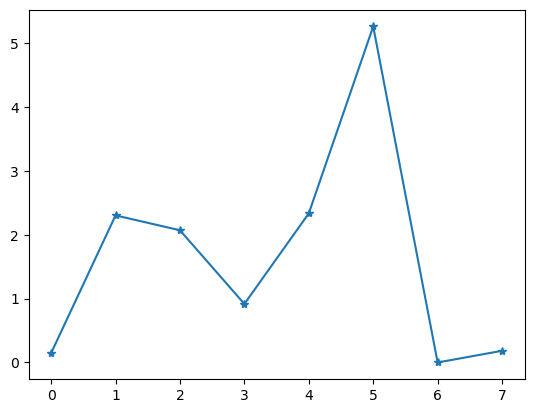

In [7]:
#plt.plot(cube.data[1:, 100, 100] - cube.data[:-1, 100, 100], '*-')
plt.plot(cube.data[:, 100, 100], '*-')
cube.data[:, 10, 100].min()